# Tutorial 1: 10x Visium colorectal cancer liver metastasis datasets

## 1 Import modules

In [1]:
import pandas as pd
import scanpy as sc
import Castl

## 2 Load data

### Generate gene lists (Option 1)

If results generated by benchmark methods are unavailable, the gene lists needs to be generated de novo. First, filter out low-expression spots and genes from the data. Then, benchmark methods are employed to identify spatially variable genes (SVGs), with each method producing the corresponding gene list.

In [2]:
adata = sc.read_visium(path='../data/CRC/ST-colon2', count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs["x_pixel"] = pd.Series(adata.obsm['spatial'][:, 1], index=adata.obs.index)
adata.obs["y_pixel"] = pd.Series(adata.obsm['spatial'][:, 0], index=adata.obs.index)
sc.pp.log1p(adata)

express_matrix, coordinates, processed_adata = Castl.data_preprocess(
    adata=adata,
    min_counts = 10,
    min_cells = 35,
    adata_path='../data/CRC/ST-colon2/processed_adata.h5ad',
    counts_path='../data/CRC/ST-colon2/counts_matrix.csv',
    coords_path='../data/CRC/ST-colon2/coordinates.csv'
)

print(processed_adata)

D:\Apps\Anaconda3\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\Apps\Anaconda3\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Initial shape: (4174, 36601)
Shape after removing mitochondrial genes: (4174, 36588)


D:\Apps\Anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:164: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Shape after quality filtering: (4174, 15414)
Saved processed AnnData to: ../data/CRC/ST-colon2/processed_adata.h5ad
Saved expression matrix to: ../data/CRC/ST-colon2/counts_matrix.csv
Saved coordinates to: ../data/CRC/ST-colon2/coordinates.csv
AnnData object with n_obs × n_vars = 4174 × 15414
    obs: 'in_tissue', 'array_row', 'array_col', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


```python
!python ../codes/spatialde_CRC.py
!python ../codes/somde_CRC.py
!python ../codes/spagcn_CRC.py
!python ../codes/spanve_CRC.py
!Rscript ../codes/spark_CRC.r
!Rscript ../codes/sparkx_CRC.r
!Rscript ../codes/heartsvg_CRC.r
```

The augmented expression matrix incorporating artificial genes was constructed using the function `create_combined_adata`. Benchmark methods are then reapplied to identify SVGs, with each method generating a corresponding gene list that includes the artificial genes for Stabl aggregation.


In [3]:
combined_adata = Castl.create_combined_adata(processed_adata, random_seed=42)
print(combined_adata)

AnnData object with n_obs × n_vars = 4174 × 30828
    obs: 'in_tissue', 'array_row', 'array_col', 'x_pixel', 'y_pixel', 'n_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


```python
!python ../codes/stabl_spatialde_CRC.py
!python ../codes/stabl_somde_CRC.py
!python ../codes/stabl_spagcn_CRC.py
!python ../codes/stabl_spanve_CRC.py
!Rscript ../codes/stabl_spark_CRC.r
!Rscript ../codes/stabl_sparkx_CRC.r
!Rscript ../codes/stabl_heartsvg_CRC.r
```

### Load gene lists (Option 2)

If results generated by benchmark methods are already available, they can be directly loaded through the following operations.

In [4]:
adata = sc.read_visium(path='../data/CRC/ST-colon2', count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs["x_pixel"] = pd.Series(adata.obsm['spatial'][:, 1], index=adata.obs.index)
adata.obs["y_pixel"] = pd.Series(adata.obsm['spatial'][:, 0], index=adata.obs.index)
sc.pp.log1p(adata)

D:\Apps\Anaconda3\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\Apps\Anaconda3\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/CRC/colon2/CRC_colon2_{method}_results_processed.csv'
    var_name = f'{method}_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

In [6]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/CRC/colon2/colon2_stabl/CRC_colon2_{method}_stabl_processed.csv'
    var_name = f'{method}_combined_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

The gene lists are in dataframe format and contain columns for `gene`, `adjusted_p_value` (or other metrics of SVG significance), and `pred`.

In [7]:
heartsvg_genelist.head()

gene  pval  adjusted_p_value  rank  pred
0     B2M   0.0               0.0     1     1
1    MYL6   0.0               0.0     2     1
2   RPL13   0.0               0.0     3     1
3  TMSB10   0.0               0.0     4     1
4   RPL41   0.0               0.0     5     1

## 3 Run Castl

Subsequently, the Castl consensus framework is implemented using the above gene lists, for which three statistical strategies provided below for selection: **rank aggregation**, **p-value aggregation**, **Stabl aggregation**.

### 3.1 Rank aggregation

The parameter `rank_col` specifies the metric value in the gene list that determines the significance level of SVGs, and `ascending=True` indicates sorting genes by this metric in ascending order of significance. Additionally, `top_percent=0.1` selects the top 10% of genes, scored by the specified metric, from the `rank_aggregation_genelist` as the final SVGs.

In [8]:
rank_agg_genelist = Castl.rank_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    rank_col='adjusted_p_value',
    ascending=True,
    top_percent=0.1
)

rank_agg_genelist.head()

gene    score  rank  pred
1568  SERPING1  97306.0     1     1
3498      NNMT  97296.0     2     1
5557    RNASE1  97263.0     3     1
8463      THY1  97169.0     4     1
9344    MALAT1  97062.0     5     1

The parameter `top_n=12` specifies visualization of the top 12 genes' expression patterns, where point and figure sizes can be adjusted via `spotsize` and `figsize` parameters, respectively.

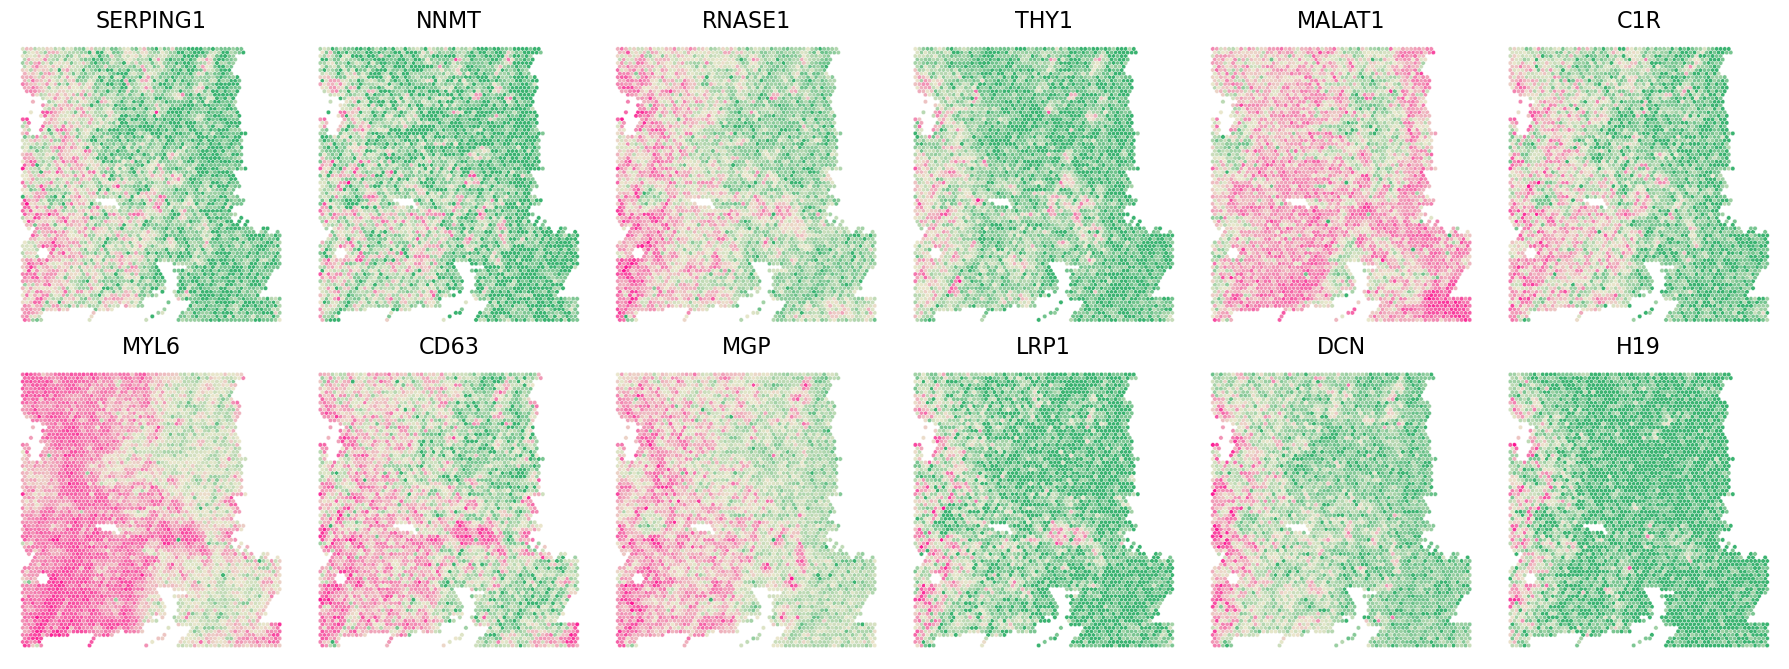

In [9]:
Castl.plot_gene(
    adata=adata,
    gene_df=rank_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='score',
    ascending=False,
    top_n=12,
    spotsize=10,
    figsize=(18, 6.8),
    invert_yaxis=True
)

### 3.2 P-value aggregation

The parameter `correction` enables selection of distinct multiple testing correction methods for combined p-values (e.g., `correction='fdr_bh'` for Benjamini-Hochberg false discovery rate control).

gene  combined_p_value  adjusted_p_value  rank  pred
0       RPL9               0.0               0.0     1     1
7583    PCP4               0.0               0.0     2     1
7581    PIN4               0.0               0.0     3     1
7578    MAP4               0.0               0.0     4     1
7576  FCGR2A               0.0               0.0     5     1

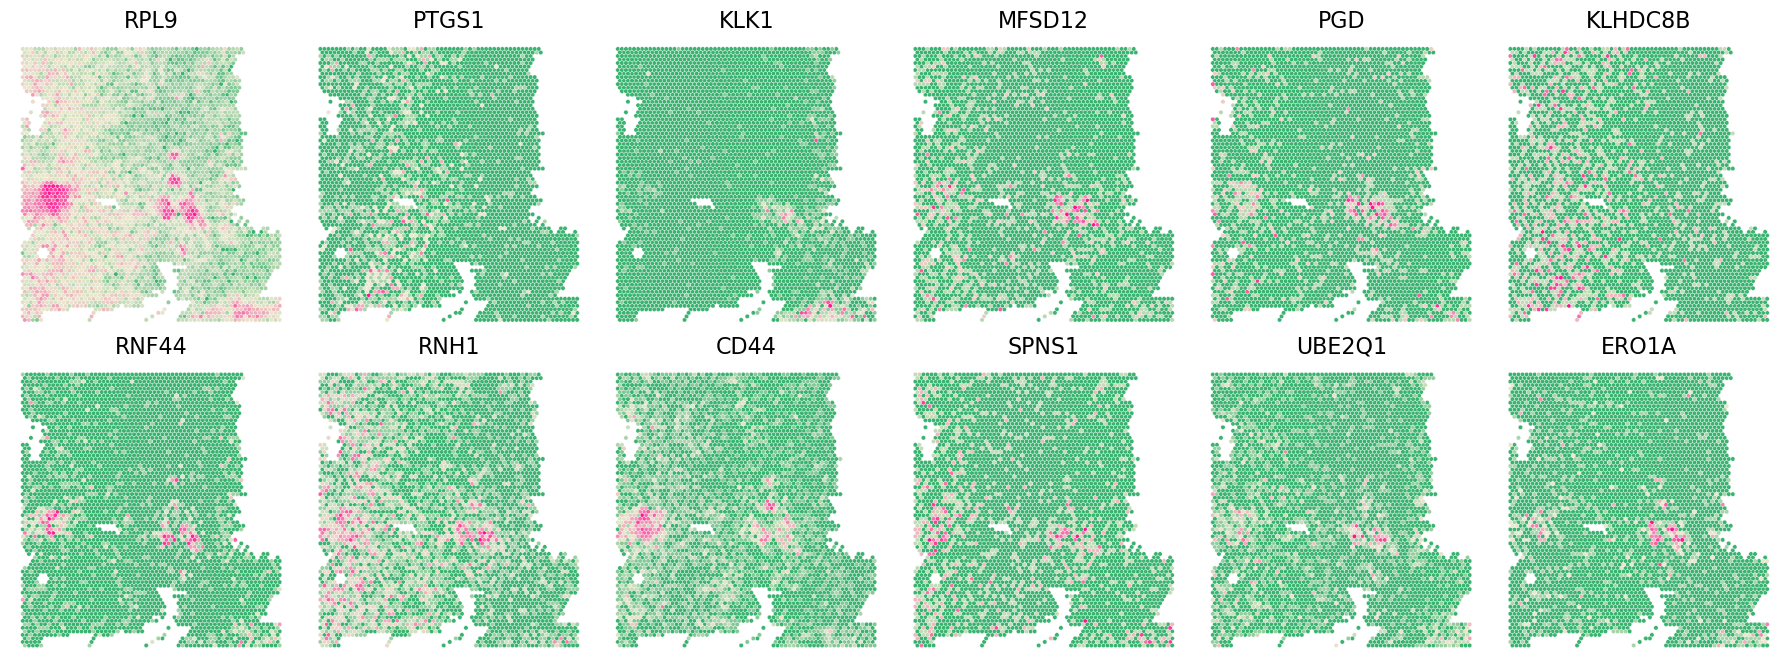

In [10]:
pval_agg_genelist = Castl.pval_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    pvalue_col='adjusted_p_value',
    correction='fdr_by'
)

Castl.plot_gene(
    adata=adata,
    gene_df=pval_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='adjusted_p_value',
    ascending=True,
    top_n=12,
    spotsize=10,
    figsize=(18, 6.8),
    invert_yaxis=True
)

pval_agg_genelist.head()

### 3.3 Stabl aggregation

The parameter `pred_col` specifies a binary classification (1: SVG; 0: non-SVG) within the dataframe-formatted gene list. The `penalty_factor` parameter (range: 0-1) controls the number of artificial gene in final selection, where 0 permits artificial genes and higher values restrict them. Empirical results indicate `penalty_factor=0.1` effectively eludes artificial genes from final selections.ion test).







Optimal threshold: 0.434
Total SVGs selected: 7995
ArtGene count in selection: 0
Non-ArtGene count in selection: 7995


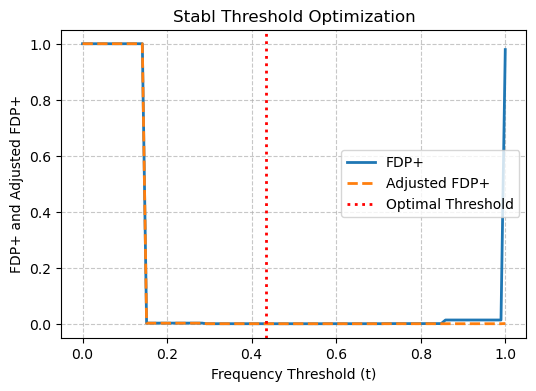

gene  frequency  rank  pred
12195  LMOD1        1.0     1     1
5416    RPS3        1.0     2     1
8553   RPL19        1.0     3     1
8546    RPSA        1.0     4     1
22543  ACTA2        1.0     5     1

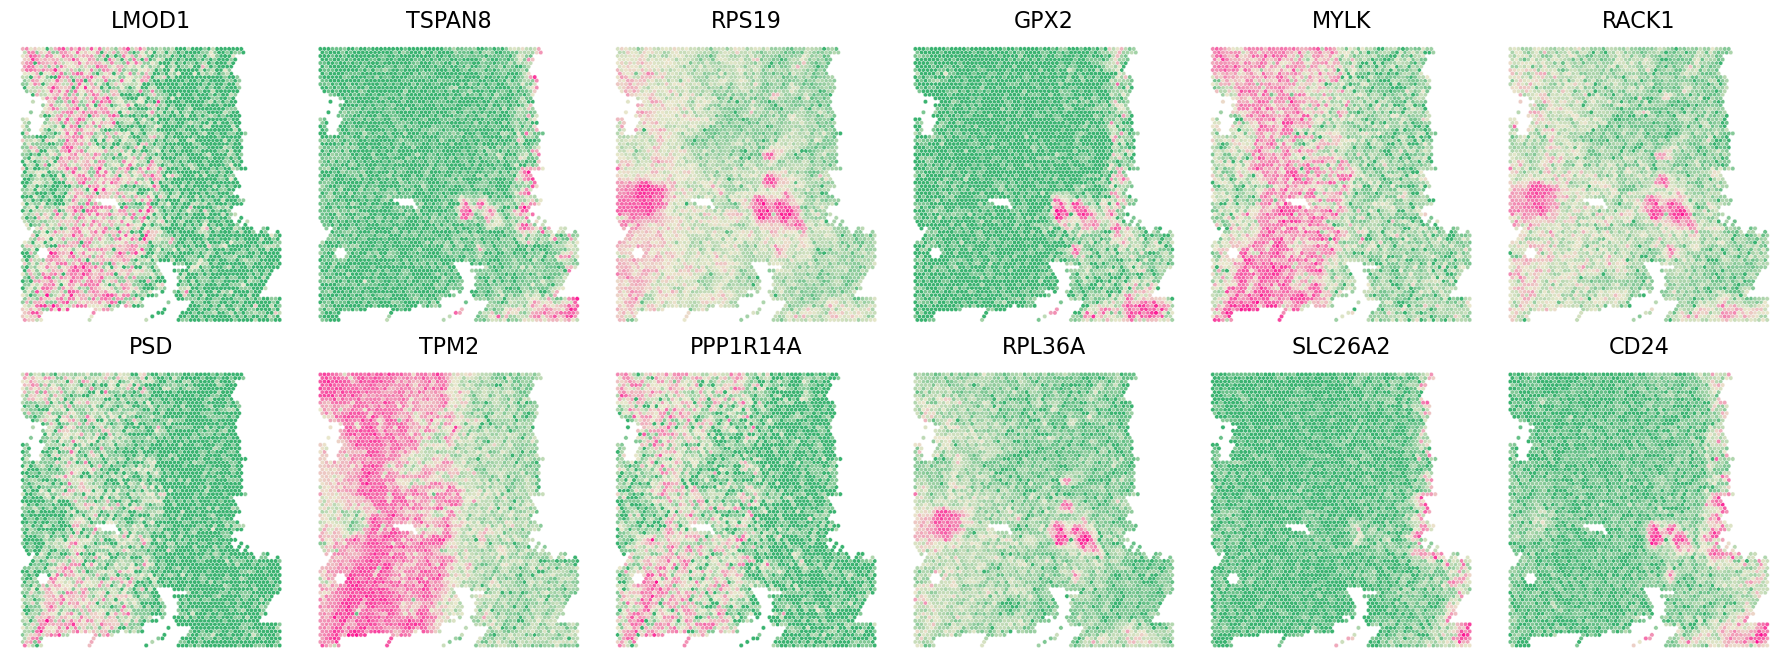

In [11]:
stabl_agg_genelist = Castl.stabl_agg(
    gene_list=[spatialde_combined_genelist, spark_combined_genelist, sparkx_combined_genelist, 
               somde_combined_genelist, spagcn_combined_genelist, spanve_combined_genelist, heartsvg_combined_genelist],
    gene_col = 'gene',
    pred_col = 'pred',
    penalty_factor=0.1,
    plot=True
)

Castl.plot_gene(
    adata=adata,
    gene_df=stabl_agg_genelist,
    x_col='y_pixel',
    y_col='x_pixel',
    gene_col='gene',
    sort_col='frequency',
    ascending=False,
    top_n=12,
    spotsize=10,
    figsize=(18, 6.8),
    invert_yaxis=True
)

stabl_agg_genelist.head()

## 4 ROC-AUC

ROC curves are plotted using gene sets downloaded from the CRCSC official website as reference sets of true SVGs to evaluate the final results.

Loaded 3768 genes from GMT file


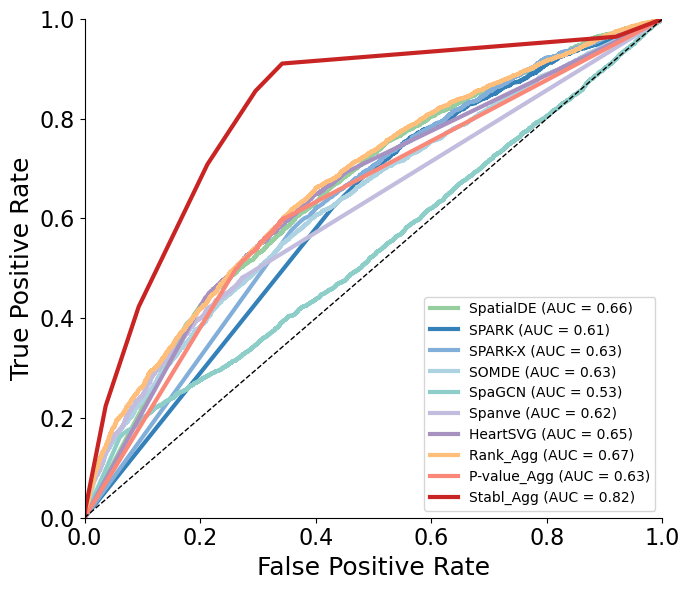

In [12]:
geneset = Castl.get_geneset('../data/CRC/genesets.gmt')

colors = ['#97ce9f', '#3480b8', '#82afda', '#add3e2', '#8dcec8', '#c2bdde', '#a791c1', '#ffbe7a', '#fa8878', '#c82423']

methods = {
    'SpatialDE': (spatialde_genelist, 'adjusted_p_value'),
    'SPARK': (spark_genelist, 'adjusted_p_value'),
    'SPARK-X': (sparkx_genelist, 'adjusted_p_value'),
    'SOMDE': (somde_genelist, 'adjusted_p_value'),
    'SpaGCN': (spagcn_genelist, 'adjusted_p_value'),
    'Spanve': (spanve_genelist, 'adjusted_p_value'),
    'HeartSVG': (heartsvg_genelist, 'adjusted_p_value'),
    'Rank_Agg': (rank_agg_genelist, 'score'),
    'P-value_Agg': (pval_agg_genelist, 'adjusted_p_value'),
    'Stabl_Agg': (stabl_agg_genelist, 'frequency'),
}

Castl.plot_ROC(
    true_labels=geneset,
    methods=methods,
    colors=colors,
    gene_col='gene',
    figsize=(7, 6),
    linewidth=3
)